In [14]:
import numpy as np
import torch
import torchvision
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import matplotlib.pyplot as plt
import tqdm
import os
from torchmetrics.classification import BinaryJaccardIndex

from segment_anything.utils.transforms import ResizeLongestSide

from datasets import Embedding_Dataset, Custom_Dataset, Cutout_Dataset
from utils import SAMPreprocess, PILToNumpy, NumpyToTensor, SamplePoint, embedding_collate, is_valid_file
from utils import create_cutouts
from models import SAM_Baseline

jaccard = BinaryJaccardIndex()

In [2]:
batch_size = 8
folder_path = '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/Liebherr/dataset'
select_mode = 'max_sim' # must be one of: 'random', 'first', 'highest_pred', 'max_sim'
visual_prompt_engineering = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAM_Baseline()

In [4]:
import clip
clip_model, clip_preprocess = clip.load("ViT-L/14@336px", device=device)
cutout_size = clip_model.visual.input_resolution
print("CLIP loaded", cutout_size)

CLIP loaded 336


In [5]:
PIXEL_MEAN = (0.48145466, 0.4578275, 0.40821073)
PIXEL_STD = (0.26862954, 0.26130258, 0.27577711)
pixel_mean = torch.Tensor(PIXEL_MEAN).reshape(3, 1, 1)
pixel_std = torch.Tensor(PIXEL_STD).reshape(3, 1, 1)

In [6]:
sam_transform = ResizeLongestSide(model.img_size)
target_transform = Compose([
    sam_transform.apply_image_torch, # rescale
    SAMPreprocess(model.img_size, normalize=False), # padding
    SamplePoint(),
])
transform = Compose([
    PILToNumpy(),
    sam_transform.apply_image, # rescale
    NumpyToTensor(),
    SAMPreprocess(model.img_size) # padding
])
example_transform = Compose([
    ToTensor(),
])

dataset = Embedding_Dataset(root=folder_path, transform=transform, target_transform=target_transform, is_valid_file=is_valid_file)
example_set = Custom_Dataset(root=folder_path, transform=example_transform, is_valid_file=is_valid_file)

dataset_size = len(dataset)
example_size = int(0.25 * dataset_size)
test_size = dataset_size - example_size
generator = torch.Generator().manual_seed(42)
test_indices, example_indices = random_split(range(len(dataset)), [test_size, example_size], generator=generator)

test_set = Subset(dataset, test_indices)
example_set = Subset(example_set, example_indices)
test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=embedding_collate)

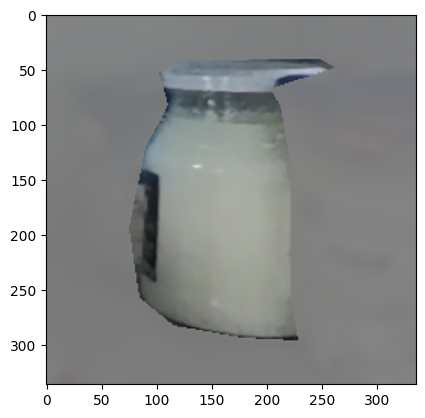

In [7]:
from torchvision.transforms import GaussianBlur

class CreateCutouts(object):
    def __init__(self, cutout_size, padding, background_transform, background_intensity):
        self.cutout_size = cutout_size
        self.padding = padding
        self.background_transform = background_transform
        self.background_intensity = background_intensity

    def __call__(self, image, masks):
        #image = (image - pixel_mean) / pixel_std # better performance without normilization
        return create_cutouts(image, masks, self.cutout_size, self.padding, self.background_transform, self.background_intensity)
        
if visual_prompt_engineering:
    background_intensity = .1
    background_transform = Compose([
        GaussianBlur(11, 10)
    ])
else:
    background_intensity = 0
    background_transform = None

create_cutouts_f = CreateCutouts(cutout_size, 30, background_transform, background_intensity)

image, masks = example_set[1]
cutouts = create_cutouts_f(image, masks)
plt.imshow(cutouts[0].permute(1, 2, 0))

In [8]:
def get_cutouts_dataset(dataset):
    cutouts_set = []
    for image, masks in tqdm.tqdm(dataset):
        cutouts = create_cutouts_f(image, masks)
        cutouts_set.append(cutouts)
    cutouts_set = Cutout_Dataset(torch.cat(cutouts_set))
    return cutouts_set

def get_example_embeddings(dataset, model, device, batch_size):
    cutouts_loader = DataLoader(dataset, batch_size=batch_size)
    examples = []
    for cutouts in tqdm.tqdm(cutouts_loader):
        cutouts = cutouts.to(device)
        cutout_embeddings = model.encode_image(cutouts)
        cutout_embeddings = cutout_embeddings[~torch.any(cutout_embeddings.isnan(), dim=1)] # remove nan embeddings
        examples.append(cutout_embeddings.detach().cpu())
    return torch.cat(examples)

In [9]:
if visual_prompt_engineering:
    file = 'example_embeddings/liebherr_vpe.pt'
else:
    file = 'example_embeddings/liebherr.pt'
    
if os.path.exists(file):
    example_embeddings = torch.load(file)
else:
    cutouts_set = get_cutouts_dataset(example_set)
    example_embeddings = get_example_embeddings(cutouts_set, clip_model, device, batch_size=16)
    torch.save(example_embeddings, file)

print(example_embeddings.shape)

100%|██████████| 250/250 [00:37<00:00,  6.71it/s]

torch.Size([3993, 768])


In [10]:
def get_closest(images, masks, examples, create_cutouts_f, model, device):
    embeddings = []
    for image, mask_suggestions in zip(images, masks):
        cutouts = create_cutouts_f(image, mask_suggestions).to(device)
        cutout_embeddings = model.encode_image(cutouts)
        embeddings.append(cutout_embeddings.detach())
    embeddings = torch.cat(embeddings)
    examples = examples.to(device)
    
    embeddings /= torch.norm(embeddings, dim=1, keepdim=True)
    examples /= torch.norm(examples, dim=1, keepdim=True)
    similarity_matrix = embeddings @ examples.T
    
    similarity_matrix = similarity_matrix.reshape(len(images), 3, len(examples))
    similarity_matrix, _ = torch.max(similarity_matrix, dim=-1)
    max_i = torch.argmax(similarity_matrix, dim=-1)
    return max_i.cpu().tolist()

In [11]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
model.to(device)
print("SAM loaded")

SAM loaded


In [12]:
def evaluate_model(model, dataloader, device): # select_mode, create_cutouts_f, clip_model
    np.random.seed(42)
    model.eval()
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        pbar = tqdm.tqdm(dataloader)
        for images, masks, points, embeddings in pbar:
            embeddings = embeddings.to(device)
            points = points.to(device)

            pred_masks, pred_iou = model(embeddings, points)
            pred_masks, pred_iou = pred_masks.cpu(), pred_iou.cpu()
            pred_masks = pred_masks > 0
            
            if select_mode == 'random':
                max_i = torch.randint(3, (len(images),))
            elif select_mode == 'first':
                max_i = torch.zeros((len(images),), dtype=int)
            elif select_mode == 'highest_pred':
                max_i = torch.argmax(pred_iou, dim=1)
            elif select_mode == 'max_sim':
                max_i = get_closest(images, pred_masks, example_embeddings, create_cutouts_f, clip_model, device)

            pred_masks = pred_masks[range(len(pred_masks)), max_i].unsqueeze(1)
            iou = jaccard(masks, pred_masks)

            total_iou += iou * images.size(0)
            total_samples += images.size(0)
            
            pbar.set_postfix({'IoU': (total_iou / total_samples).item()})

    average_iou = total_iou / total_samples
    return average_iou

In [13]:
iou_score = evaluate_model(model, test_loader, device)
print('IoU: {:.4f}'.format(iou_score), flush=True)

100%|██████████| 80/80 [03:36<00:00,  2.70s/it, IoU=0.464]

IoU: 0.4638
